In [ ]:
# Use "conda install -c conda-forge python-sounddevice" for installing sounddevice for recording

In [2]:
pip install librosa

  Using cached https://files.pythonhosted.org/packages/51/dd/0e015051b4a27ec5a58b02ab774059f3289a94b0906f880a3f9507e74f38/joblib-0.16.0-py3-none-any.whl
  Created wheel for librosa: filename=librosa-0.8.0-cp37-none-any.whl size=201381 sha256=412b223040880a58537be26a649cc852309bceb163be861d143b2e680011628c
  Stored in directory: C:\Users\SITS\AppData\Local\pip\Cache\wheels\ee\10\1e\382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
  Created wheel for audioread: filename=audioread-2.1.8-cp37-none-any.whl size=23097 sha256=9b9f25acd7d2fa3bcdd2d55ce0ad8421936f1fbe09a7607d64425c2dce9ebf36
  Stored in directory: C:\Users\SITS\AppData\Local\pip\Cache\wheels\b9\64\09\0b6417df9d8ba8bc61a7d2553c5cebd714ec169644c88fc012
  Created wheel for resampy: filename=resampy-0.2.2-cp37-none-any.whl size=320724 sha256=e7b8ed6618f12f2572a121e112e3083e59de502429f039387e3550193e50f42a
  Stored in directory: C:\Users\SITS\AppData\Local\pip\Cache\wheels\fa\c1\56\e0e12c6f7f3d2cdea9712b35136a2d40a7817c6210ec09648

In [3]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
#We use 1 dimensional arrays due to audio files, we use Conv1D and MaxPooling1D
#Dense is used for connecting the entire neural network
#Flattening is the process of converting all the resultant 1D arrays into a single long continuous linear vector
#A dropout layer is used for regularization where you randomly set some of the dimensions of your input vector to be zero
from keras.models import Model #Used to instantiate a Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot 
import random
import soundfile as sf

Using TensorFlow backend.


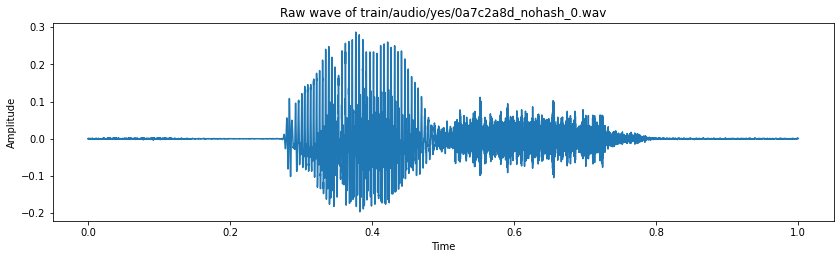

In [5]:
train_audio_path = 'train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8)) #FigSize determines the pixels of the plot
ax1 = fig.add_subplot(211) #Subplot grid parameter of 2x1 at the top left of the plot
ax1.set_title('Raw wave of ' + 'train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [6]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [7]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

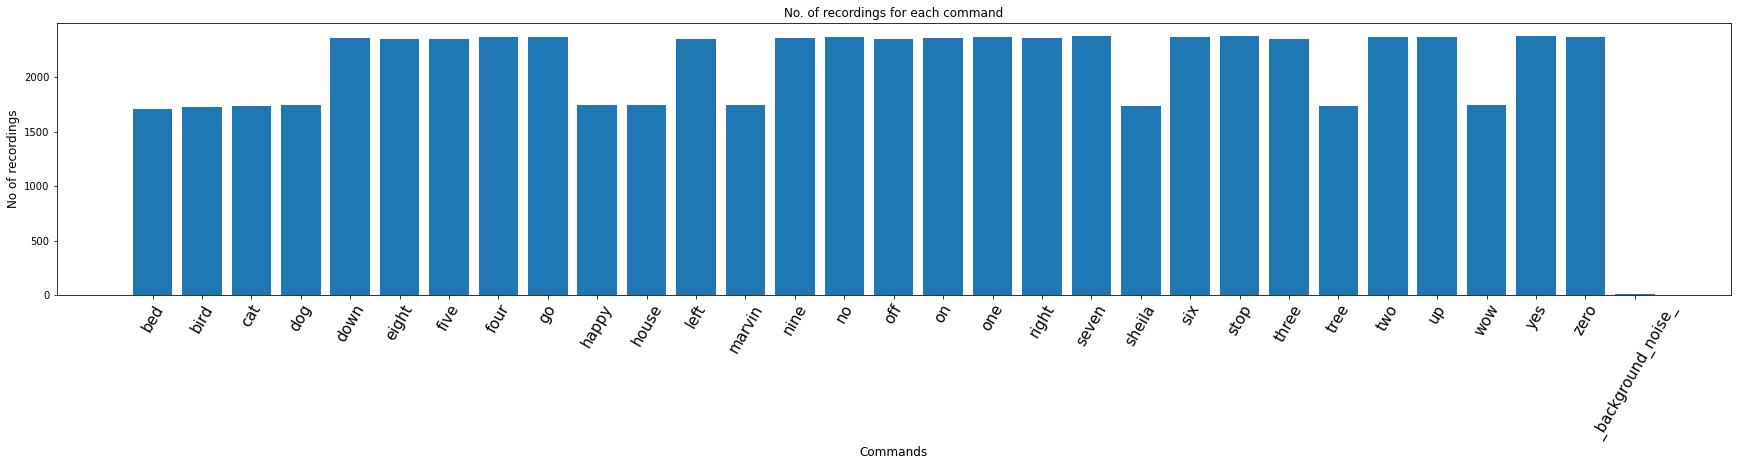

In [8]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "wow", "house", "happy", "tree", "dog", "cat", "bird", 
        "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

(array([1.2000e+01, 1.8000e+01, 1.6600e+02, 1.4700e+02, 3.4300e+02,
        5.8200e+02, 8.5600e+02, 7.1300e+02, 1.2580e+03, 5.3057e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

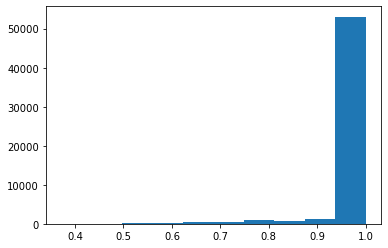

In [9]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [16]:
train_audio_path = 'train\\audio'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '\\'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go
wow
house
happy
tree
dog
cat
bird
one
two
three
four
five
six
seven
eight
nine


In [17]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [18]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [19]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [20]:
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 41127 samples, validate on 10282 samples
Epoch 1/100
41127/41127 [==============================] - 567s 14ms/step - loss: 2.6983 - accuracy: 0.1795 - val_loss: 1.9856 - val_accuracy: 0.3767
Epoch 2/100
41127/41127 [==============================] - 614s 15ms/step - loss: 1.9404 - accuracy: 0.3780 - val_loss: 1.6638 - val_accuracy: 0.4831
Epoch 3/100
41127/41127 [==============================] - 604s 15ms/step - loss: 1.6803 - accuracy: 0.4557 - val_loss: 1.4896 - val_accuracy: 0.5355
Epoch 4/100
41127/41127 [==============================] - 618s 15ms/step - loss: 1.5218 - accuracy: 0.5095 - val_loss: 1.3016 - val_accuracy: 0.6002
Epoch 5/100
41127/41127 [==============================] - 621s 15ms/step - loss: 1.3848 - accuracy: 0.5594 - val_loss: 1.1925 - val_accuracy: 0.6368
Epoch 6/100
41127/41127 [==============================] - 616s 15ms/step - loss: 1.2607 - accuracy: 0.6014 - val_loss: 1.0053 - val_accuracy: 0.6990
Epoch 7/100
41127/41127 [=========================

In [ ]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
'''from keras.models import load_model
model=load_model('best_model.hdf5')'''

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

In [ ]:
os.listdir('../input/tensorflow-speech-recognition-challenge/train/audio/right')
filepath='../input/tensorflow-speech-recognition-challenge/train/audio/right'

In [ ]:
#import wave
#reading the voice commands
#Audio should not be of 24 sample size (8,16 or 32) use AUDACITY to record or edit
#samples = wave.open(filepath + '/' + 'stop.wav', 'wb')
#samples.setnchannels(1) # mono
samples, sample_rate = librosa.load(filepath + '/' + '4c7c95de_nohash_1.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [ ]:
predict(samples)